# Objective

The objective of this notebook is to explore the effects of different binding kinetics of bispecific T cell engagers in the tumor microenvironment.

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures

# Trimer formation in tumor micro environment

Drug concentration in the medium is $X$, CD3 target is $T_1$ and Pcad concentration is $T_2$. No internalization or drug degradation.


\begin{align}
        \dot{X} &  = - k_{n1} T_1 X - k_{n2} T_2 X + k_{f1} D_1 + k_{f2} D_2,\\
        \dot{T_1} & = - k_{n1} T_1 X + k_{f1} D_1 - k_{n1} T_1 D_2 + k_{f1} Y,\\
        \dot{T_2} & = - k_{n2} T_2 X + k_{f2} D_2 - k_{n2} T_2 D_1 + k_{f2} Y,\\
        \dot{D_1} & = k_{n1} T_1 X - k_{f1} D_1 - k_{n2} T_2 D_1 + k_{f2} Y,\\
        \dot{D_2} & = k_{n2} T_2 X + k_{f2} D_2 - k_{n1} T_1 D_2 + k_{f1} Y,\\
        \dot{Y} & = k_{n1} T_1 D_2 + k_{n2} T_2 D_1 - (k_{f1}+k_{f2}) Y.
\end{align}


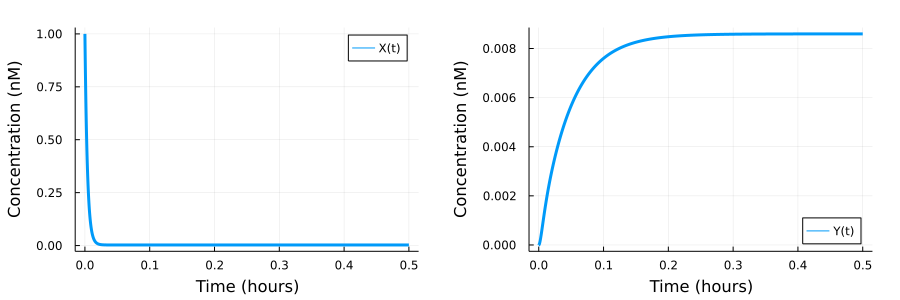

In [2]:
function dish(du,u,p,t)
    X, T1ₜ, T2ₜ, D1ₜ, D2ₜ, Y = u
    kn₁, kf₁, kn₂, kf₂ = p 
    du[1]= -kn₁*T1ₜ*X -kn₂*T2ₜ*X +kf₁*D1ₜ +kf₂*D2ₜ
    du[2]= -kn₁*T1ₜ*X +kf₁*D1ₜ -kn₁*T1ₜ*D2ₜ +kf₁*Y
    du[3]= -kn₂*T2ₜ*X +kf₂*D2ₜ -kn₂*T2ₜ*D1ₜ +kf₂*Y
    du[4]= +kn₁*T1ₜ*X -kf₁*D1ₜ -kn₂*T2ₜ*D1ₜ +kf₂*Y
    du[5]= +kn₂*T2ₜ*X -kf₂*D2ₜ -kn₁*T1ₜ*D2ₜ +kf₁*Y
    du[6]= +kn₁*T1ₜ*D2ₜ +kn₂*T2ₜ*D1ₜ -(kf₁+kf₂)*Y
end

x0 = [1e0,1.08e-1,166,0.0,0.0,0.0]
ts = (0.0,0.5)
p  = [1.72,19.66,1.57,0.74]
dishproblem = ODEProblem(dish,x0,ts,p)
ds = solve(dishproblem, abstol=1e-18, reltol=1e-18)

p1 = plot(ds.t, ds[1,:],linewidth=3,label="X(t)",
         ylabel="Concentration (nM)", xlabel="Time (hours)")
p2 = plot(ds.t, ds[6,:],linewidth=3,label="Y(t)",
         ylabel="Concentration (nM)", xlabel="Time (hours)", legend=:bottomright)
plot(p1,p2, layout=(1,2), size=(900,300), margin=5mm)

# Dish experiments

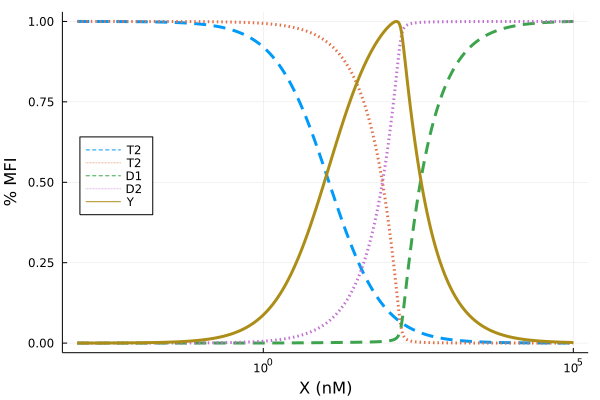

In [3]:
function simulate(problem, dose)
    ss = zeros(length(dose),6)
    problem = remake(problem; tspan=(0.0,1e3))
    for index=1:length(dose) 
        problem_ = remake(problem, u0=vcat(dose[index], problem.u0[2:end]))
        solution = solve(problem_)
        ss[index,:] = solution[:,end]'
    end
    return ss
end

function mfi(problem,l,b, name)
    dose = 10 .^(range(l,b,length=1000)) # change l and b customize x axis
    m = simulate(problem, dose)
    p = plot(dose, m[:,2]./maximum(m[:,2]), label="T2", xaxis=:log,
        linewidth=3, ylabel="% MFI", xlabel="X (nM)",
        legend=:left, linestyle=:dash)
    p = plot!(p,dose, m[:,3]./maximum(m[:,3]), label="T2", linewidth=3, linestyle=:dot)
    p = plot!(p,dose, m[:,4]./maximum(m[:,4]), label="D1", linewidth=3, linestyle=:dash)
    p = plot!(p,dose, m[:,5]./maximum(m[:,5]), label="D2", linewidth=3, linestyle=:dot)
    p = plot!(p,dose, m[:,6]./maximum(m[:,6]), label="Y", linewidth=3)
    savefig(p, "figures/"*name*".png")
    savefig(p, "figures/"*name*".pdf")
    display(p)
end

mfi(dishproblem,-3,5, "Dish_1")

### Regular experiment style

The complete bell shape is missing in most published experimental results. Let's see what will happen if focus on the linear part e.g. left side of the horizontal axis, in the figure above.

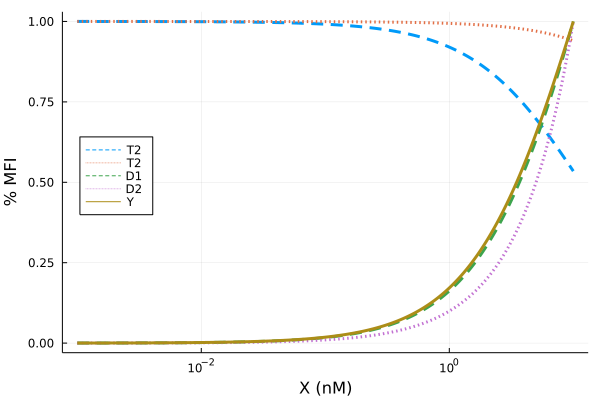

In [4]:
mfi(dishproblem,-3,1, "Dish_2")

# Optimal antibody concentration



In [5]:
# identify maximum trimer value and drug dose
function optimal(problem,dim)
    dose = 10 .^(range(-6,6,length=10000)) 
    long = simulate(problem, dose)
    value, index = findmax(long[:,dim])
    return [value, dose[index]]
end

optimal(dishproblem,6)

2-element Vector{Float64}:
   0.09820674561524748
 140.480085044108

## Parameter sweep

Based on dissociation and initial concentration of Betts et al model.

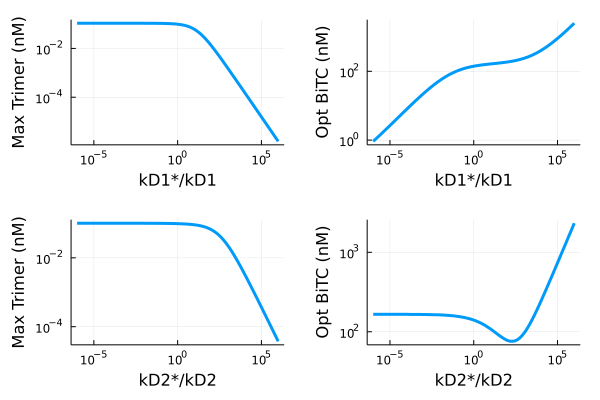

In [6]:
function s2d(problem, name)
    resolution = 100
    trimer = zeros(2,resolution)
    opdrug = zeros(2,resolution)
    drange = 10 .^(range(-6,6,length=resolution))
    for index = 1:resolution
        problem1 = remake(problem, p =vcat(problem.p[1], 
                drange[index]*problem.p[2], problem.p[3:4]))
        trimer[1,index], opdrug[1,index] = optimal(problem1,6)
        problem2 = remake(problem, p =vcat(problem.p[1:3], 
                drange[index]*problem.p[4]))
        trimer[2,index], opdrug[2,index] = optimal(problem2,6)
    end
    p1 = plot(drange,trimer[1,:], xaxis=:log, ylabel="Max Trimer (nM)",
        linewidth=3, label=:false, xlabel="kD1*/kD1", yaxis=:log)
    p2 = plot(drange,opdrug[1,:], xaxis=:log, ylabel="Opt BiTC (nM)",
        linewidth=3, label=:false, xlabel="kD1*/kD1", yaxis=:log)
    p3 = plot(drange,trimer[2,:], xaxis=:log, ylabel="Max Trimer (nM)",
        linewidth=3, label=:false, xlabel="kD2*/kD2", yaxis=:log)
    p4 = plot(drange,opdrug[2,:], xaxis=:log, ylabel="Opt BiTC (nM)",
        linewidth=3, label=:false, xlabel="kD2*/kD2", yaxis=:log)
    p = plot(p1,p2,p3,p4,layout=(2,2), size=(600,400), margin=3mm) 
    savefig(p, "figures/"*name*".png")
    savefig(p, "figures/"*name*".pdf")
    return p
end

s2d(dishproblem, "Dish_3")

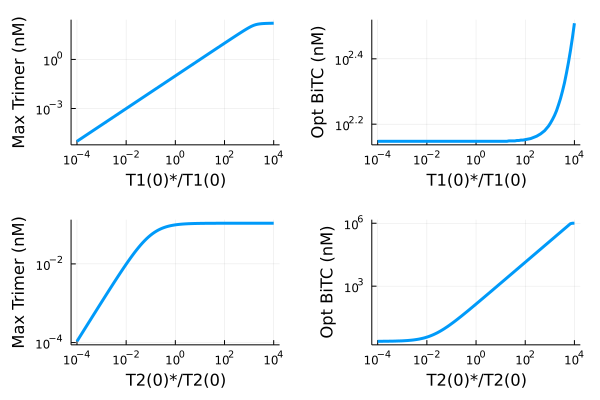

In [7]:
function s2c(problem, name)
    resolution = 100
    trimer = zeros(2,resolution)
    opdrug = zeros(2,resolution)
    drange = 10 .^(range(-4,4,length=resolution))
    for index = 1:resolution
        problem1 = remake(problem, u0=vcat(problem.u0[1], 
                drange[index]*problem.u0[2], problem.u0[3:end]))
        problem2 = remake(problem, u0=vcat(problem.u0[1:2], 
                drange[index]*problem.u0[3], problem.u0[4:end]))
        trimer[2,index], opdrug[2,index] = optimal(problem2,6)
        trimer[1,index], opdrug[1,index] = optimal(problem1,6)
    end
    p1 = plot(drange,trimer[1,:], xaxis=:log, ylabel="Max Trimer (nM)",
        linewidth=3, label=:false, xlabel="T1(0)*/T1(0)", yaxis=:log)
    p2 = plot(drange,opdrug[1,:], xaxis=:log, ylabel="Opt BiTC (nM)",
        linewidth=3, label=:false, xlabel="T1(0)*/T1(0)", yaxis=:log)
    p3 = plot(drange,trimer[2,:], xaxis=:log, ylabel="Max Trimer (nM)",
        linewidth=3, label=:false, xlabel="T2(0)*/T2(0)", yaxis=:log)
    p4 = plot(drange,opdrug[2,:], xaxis=:log, ylabel="Opt BiTC (nM)",
        linewidth=3, label=:false, xlabel="T2(0)*/T2(0)", yaxis=:log)
    p = plot(p1,p2,p3,p4,layout=(2,2), size=(600,400), margin=3mm) 
    savefig(p, "figures/"*name*".png")
    savefig(p, "figures/"*name*".pdf")
    return p
end

s2c(dishproblem, "Dish_4")

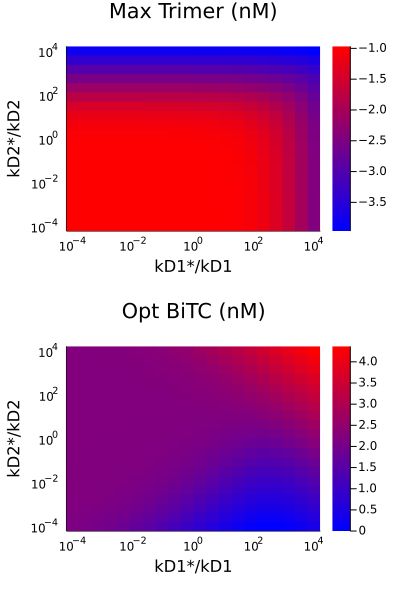

In [8]:
function dismap(problem)
    resolution = 20
    trimer = zeros(resolution,resolution)
    opdrug = zeros(resolution,resolution)
    vector = range(-4,4,length=resolution)
    drange = 10 .^ vector
    for i1 = 1:resolution
        for i2 = 1:resolution
            problem_ = remake(problem, p =vcat(problem.p[1], 
                    drange[i1]*problem.p[2], problem.p[3],
                    drange[i2]*problem.p[4], problem.p[5:end]))
            trimer[i1,i2], opdrug[i1,i2] = optimal(problem_,6)
        end
    end
    p1 = heatmap(drange, drange, log10.(trimer), c=cgrad([:blue, :red])
        , xscale=:log10, yscale=:log10, xlabel="kD1*/kD1"
        , ylabel="kD2*/kD2", title="Max Trimer (nM)", size=(400,300))
    savefig(p1, "figures/h1.png")
    savefig(p1, "figures/h1.pdf")
    p2 = heatmap(drange, drange, log10.(opdrug), c=cgrad([:blue, :red])
        , xscale=:log10, yscale=:log10, xlabel="kD1*/kD1"
        , ylabel="kD2*/kD2", title="Opt BiTC (nM)", size=(400,300))
    savefig(p2, "figures/h2.png")
    savefig(p2, "figures/h2.pdf")
    plot(p1, p2, layout=(2,1), size=(400,600), margin=3mm)
end

dismap(dishproblem)

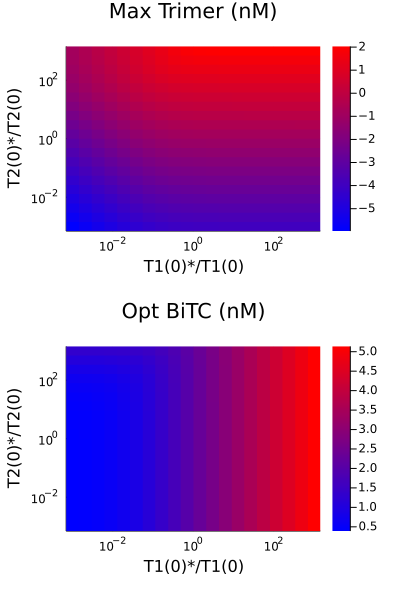

In [9]:
function conmap(problem)
    resolution = 20
    trimer = zeros(resolution,resolution)
    opdrug = zeros(resolution,resolution)
    vector = range(-3,3,length=resolution)
    drange = 10 .^ vector
    for i1 = 1:resolution
        for i2 = 1:resolution
            problem_ = remake(problem, u0=vcat(problem.u0[1], 
                    drange[i1]*problem.u0[2], drange[i2]*problem.u0[3],
                    problem.u0[4:end]))
            trimer[i1,i2], opdrug[i1,i2] = optimal(problem_,6)
        end
    end
    p1 = heatmap(drange, drange, log10.(trimer), c=cgrad([:blue, :red])
        , xscale=:log10, yscale=:log10, xlabel="T1(0)*/T1(0)"
        , ylabel="T2(0)*/T2(0)", title="Max Trimer (nM)", size=(400,300))
    savefig(p1, "figures/h3.png")
    savefig(p1, "figures/h3.pdf")
    p2 = heatmap(drange, drange, log10.(opdrug), c=cgrad([:blue, :red])
        , xscale=:log10, yscale=:log10, xlabel="T1(0)*/T1(0)"
        , ylabel="T2(0)*/T2(0)", title="Opt BiTC (nM)", size=(400,300))
    savefig(p2, "figures/h4.png")
    savefig(p2, "figures/h4.pdf")
    plot(p1, p2, layout=(2,1), size=(400,600), margin=3mm)
end

conmap(dishproblem)

# Adjourn

In [10]:
using Dates
println("mahdiar")
Dates.format(now(), "Y/U/d HH:MM")

mahdiar


"2022/June/10 10:16"